In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYPI4UP/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYPI4UP/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYPI4UP/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [6]:
# learning rate
learning_rate = 0.01

# optimizers
optimizer = tf.keras.optimizers.Adam(learning_rate) # adam
# optimizer = tf.keras.optimizers.RMSprom(learning_rate) # rms prop

In [7]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [8]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 722s 2s/step - loss: 0.5305 - accuracy: 0.6978 - val_loss: 0.3705 - val_accuracy: 0.8130
Epoch 2/10
391/391 [==============================] - 716s 2s/step - loss: 0.3448 - accuracy: 0.8464 - val_loss: 0.3441 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 708s 2s/step - loss: 0.3152 - accuracy: 0.8630 - val_loss: 0.3239 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 706s 2s/step - loss: 0.2912 - accuracy: 0.8742 - val_loss: 0.3172 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 711s 2s/step - loss: 0.2678 - accuracy: 0.8864 - val_loss: 0.3311 - val_accuracy: 0.8667
Epoch 6/10
391/391 [==============================] - 713s 2s/step - loss: 0.2561 - accuracy: 0.8885 - val_loss: 0.3045 - val_accuracy: 0.8672
Epoch 7/10
391/391 [==============================] - 702s 2s/step - loss: 0.2413 - accuracy: 0.8974 - val_loss: 0.3242 - val_accuracy: 0.8531

In [12]:
history.history

{'loss': [0.5304535031318665,
  0.3447605073451996,
  0.31521472334861755,
  0.29120492935180664,
  0.26779183745384216,
  0.2560882568359375,
  0.24125517904758453,
  0.22971688210964203,
  0.2185586392879486,
  0.21151454746723175],
 'accuracy': [0.6977999806404114,
  0.8464400172233582,
  0.8630399703979492,
  0.874239981174469,
  0.8863599896430969,
  0.888480007648468,
  0.8973600268363953,
  0.902679979801178,
  0.9071599841117859,
  0.9115599989891052],
 'val_loss': [0.3704848289489746,
  0.344062477350235,
  0.3238540589809418,
  0.31723707914352417,
  0.3310805857181549,
  0.30448973178863525,
  0.32424962520599365,
  0.3692307472229004,
  0.3239496052265167,
  0.3472181558609009],
 'val_accuracy': [0.8130208253860474,
  0.8447916507720947,
  0.8500000238418579,
  0.8604166507720947,
  0.8666666746139526,
  0.8671875,
  0.8531249761581421,
  0.856249988079071,
  0.8677083253860474,
  0.8588541746139526]}

(0.0, 0.5464004509150981)

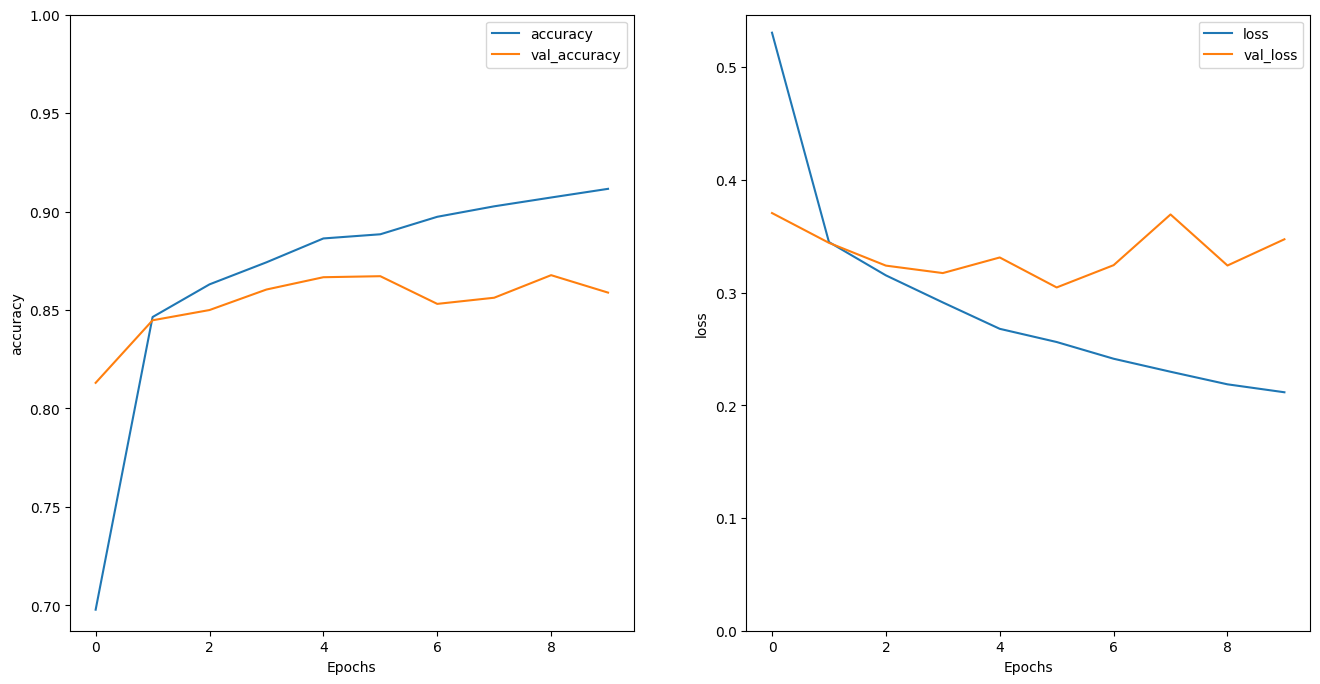

In [10]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [11]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 178s 453ms/step - loss: 0.3249 - accuracy: 0.8692
Test Loss: 0.32490184903144836
Test Accuracy: 0.8692399859428406
